In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pystan
import seaborn
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import copy 
warnings.filterwarnings("ignore")


##**Section 1: Data Analysis.**

In [0]:
#reading the data
data = pd.read_csv("https://raw.githubusercontent.com/MoGaber/aaa/master/weekly_in_situ_co2_mlo2.csv")

In [3]:
data

,Date,Concentration(ppm)
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48
...,...,...
3134,2019-08-31,409.32
3135,2019-09-07,408.80
3136,2019-09-14,408.61
3137,2019-09-21,408.50


I'm going to turn the dates given in the dataset into weeks since the measurement is done every week. The first point will be our reference point to which the date will be 0 corresponding to 0 weeks.

In [0]:
weeks = [0] #the weeks list
for i in range(1,len(data)):
  d1 = datetime.strptime(data.Date[0], "%Y-%m-%d")
  d2 = datetime.strptime(data.Date[i], "%Y-%m-%d")
  weeks.append((d2-d1).days//7) #caclulate how many weeks each date starting from the reference point.

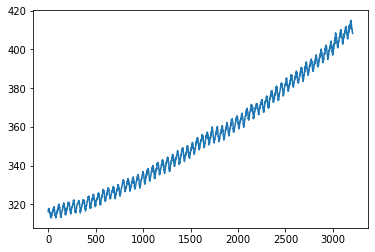

In [5]:
#plotting the data:
plt.plot(weeks, data["Concentration(ppm)"])

##**Section 2: Modeling.**

To visualize the overall trend better and to get an idea on which model might be most suitable, we can make a plot of the concentration which should show the overall trend better:

In [0]:
year = [] #this list will contain the years
concentration=[]#this list will contain the concentrations of each year
for i, date in enumerate(data.Date):
    if date[0:4] not in year:
        year.append(date[0:4])
        concentration.append(data.iloc[i][1])
    

Now, I'm going to plot the years and the concentration and will try to plot two lines on them: one linear and one polynomial to see the nature of the overall trend:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


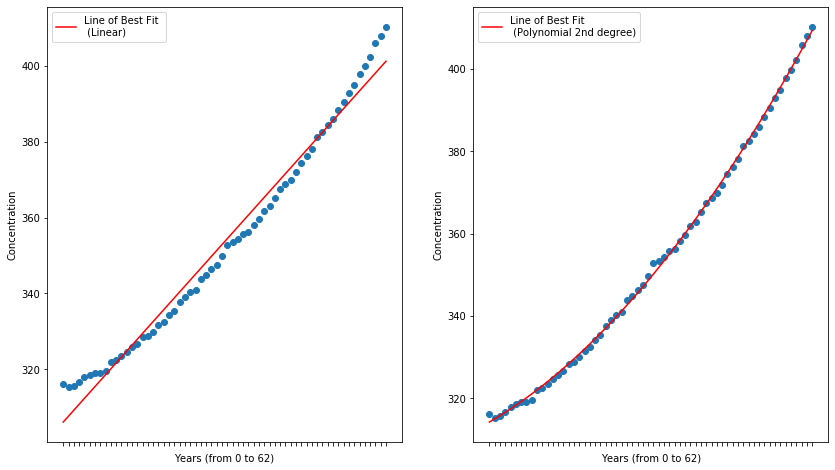

In [7]:
x = range(len(year)) #since the years are strings, I will represent them using number from 0 to 62 since we have 62 years
y = concentration

plt.subplots(1,2,figsize=(14,8))

#plot with linear line of best fit
plt.subplot(1,2, 1)
plt.scatter(year, concentration)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.xlabel("Years (from 0 to 62)")
plt.ylabel('Concentration')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'red', label = 'Line of Best Fit \n (Linear)')
plt.legend()

#plot with polynomial line of best fit
plt.subplot(1,2, 2)
plt.scatter(year, concentration)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.xlabel("Years (from 0 to 62)")
plt.ylabel('Concentration')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), color = 'red', label = 'Line of Best Fit \n (Polynomial 2nd degree)')
plt.legend()



plt.show()

Looking the two plots above, we see that the overall trend is not linear so a linear model, would do a poor job at predicting the concentrations in the future. However, a polynomial of 2nd degree seems to fit the data pretty well so that sounds to be a much better model.

##**Building the models**
The visualization that we did above show that a linear model is not the best and a polynomial model of 2nd degree should fit the data much better. I'm going to build the two models using Stan and plot them against the observed data to check that.

**The given Linear Model**

First, I will start with the linear model (the model given in the assignment):
In this model, I'm going to model 5 paramters:
- c_0: the initial value 
- c_1: the coefficient of the linear model
- c_2: The amplitude of the seasonal variation
- c_3: phi which is periodic for the seasonal variation
- sigma: which is used to model the random noise in the data

Since I don't have much information about these paramters, then I'm going to use a cauchy distributions as my prior functions because it's a broad distribution that should work in this case when we don't have much information about the priors. I will use a normal distrubtion with relatively smaller variance since the randomness is not very large.

In [0]:
stan_code_given = """
data {
    int<lower=1> n;        
    real<lower=0> concentration[n]; 
    real<lower=0> weeks[n];            
    
}

parameters {
    real<lower=0> c_0;  
    real<lower=0> c_1;
    real<lower=0> c_2;
    real<lower=0, upper=1> c_3;  //restricting this variable since this is phi that should be periodic between 0 and 1
    
    real sigma; 

 
}


model {
  
  // My prior distributions:

    c_0 ~ cauchy(0, 0.1);
    c_1 ~ cauchy(0, 1);
    c_2 ~ cauchy(0, 1);
    c_3 ~ cauchy(0, 1);
    sigma ~ normal(0, 1);
    
    
    // My likelihood function:

    for(i in 1:n) {
        concentration[i] ~ normal(
            c_0+c_1*weeks[i]+ (c_2 * cos((2*pi()*weeks[i])/365.25 + c_3)),
            sigma);

           
    }
}


"""



In [9]:
stan_model_given = pystan.StanModel(model_code=stan_code_given)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ac8c9a75c1075f5a2898a3f67393ec1 NOW.


In [0]:
stan_data = {
    'n':len(data),
    'concentration': data['Concentration(ppm)'],
    'weeks': weeks} 


In [11]:
results_model_given = stan_model_given.sampling(data=stan_data)
print(results_model_given.stansummary())

Inference for Stan model: anon_model_8ac8c9a75c1075f5a2898a3f67393ec1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0   306.07  2.5e-3   0.16 305.76 305.96 306.07 306.17 306.37   3909   1.01
c_1     0.03  1.3e-6 8.2e-5   0.03   0.03   0.03   0.03   0.03   3803    1.0
c_2     0.02  3.8e-4   0.02 5.2e-4 6.5e-3   0.01   0.03   0.08   2814    1.0
c_3     0.46  6.8e-3   0.28   0.02   0.21   0.44   0.69   0.97   1745    1.0
sigma   4.26  1.2e-3   0.05   4.15   4.22   4.26   4.29   4.37   2030    1.0
lp__   -6155    0.05   1.72  -6159  -6156  -6155  -6154  -6153   1403    1.0

Samples were drawn using NUTS at Fri Dec 20 06:47:09 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The Stan summary shows that the Markov chains converged well since we have values of Rhat between 1.1 and 0.9 and the number of effective samples is larger than few hundreds. This means that this model generates resonable uncorrelated data points. This means that the chains didn't get stuck anywhere (no multimodality). We can check that by plotting the autocorrelation plots and the pair plots:

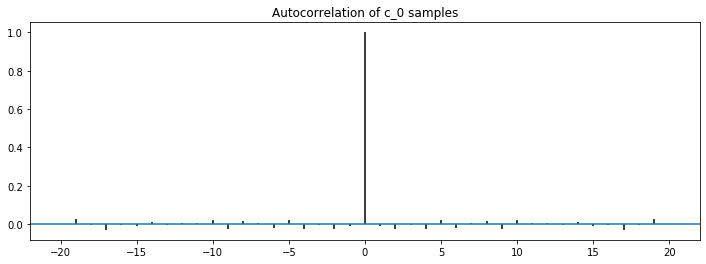

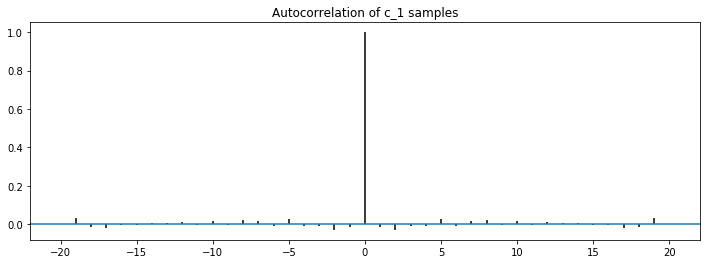

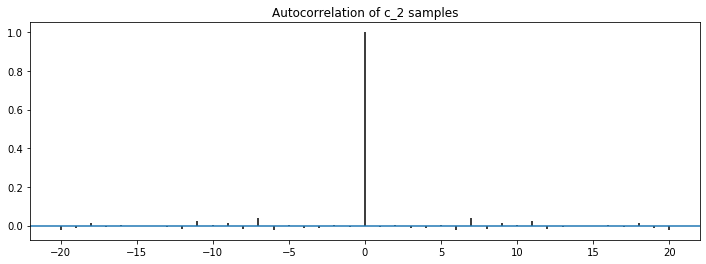

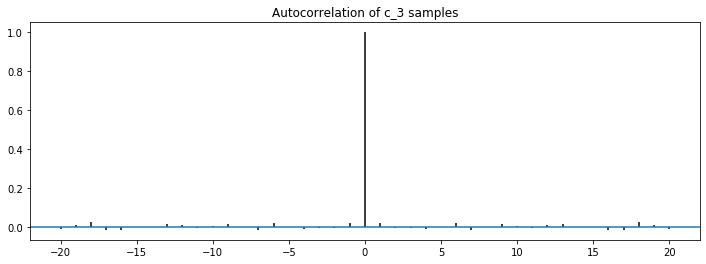

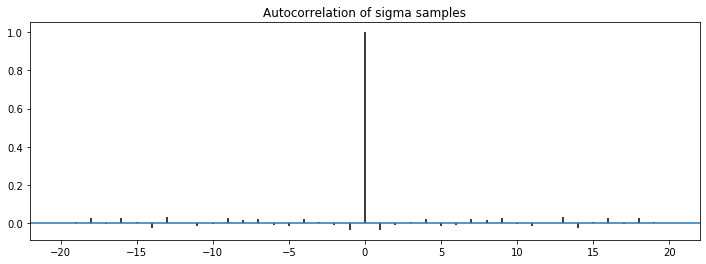

In [12]:
#autocorrelation plots:
linear_samples = results_model_given.extract()
parameters = ['c_0', 'c_1', 'c_2', 'c_3', 'sigma']

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. 
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(linear_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

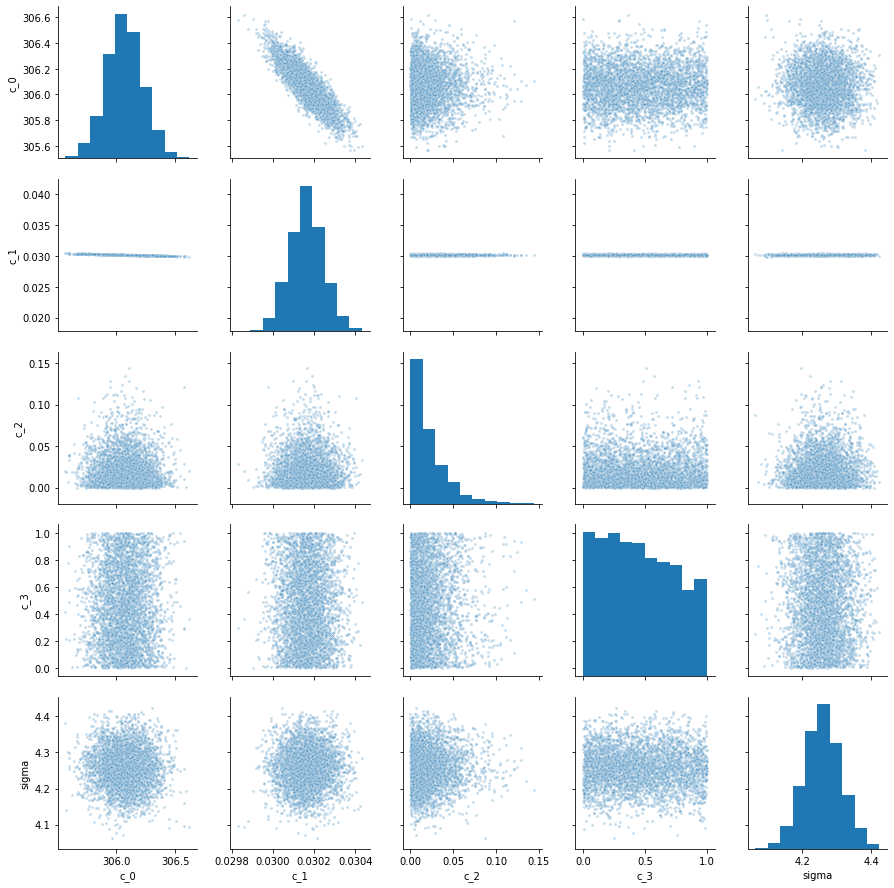

In [13]:
#pair plots:
df = pd.DataFrame(
    data=np.transpose([linear_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

The graphs agree with our expectations that the samples extracted are not correlated and the pair plots show that the chains converged without multimodality.

**The second degree polynomial model**

Now, I will build the polynomial model which, according to our earlier visualization, is expected to do better than the linear model. The overall trend of this model will be simulated using a polynomial of the second degree (c_0+c_1x+c_2x^2)

In this model, I'm going to model 6 paramters.
- c_0: the initial value 
- c_1: the coefficient of x in the polynomial
- c_2: the coefficient of x^2 in the polynomial
- c_2: The amplitude of the seasonal variation
- c_4: phi which is periodic for the seasonal variation
- sigma: which is used to model the random noise in the data


Since I don't have much information about these paramters, then I'm going to use a cauchy distributions as my prior functions because it's a broad distribution that should work well in this case when we don't have much information about the priors. I will use a normal distrubtion with relatively smaller variance since the randomness is not very large.

A factor graph that represents the mode can be found here:
https://drive.google.com/file/d/1yVHSKHBIIiJPa5k6O_O7jDoIy8YXgtAV/view?usp=sharing

In [0]:
stan_code_edited = """
data {
    int<lower=1> n;        
    real<lower=0> concentration[n];
    real<lower=0> weeks[n];            
    
}

parameters {
    real<lower=0> c_0;
    real<lower=0> c_1;
    real<lower=0> c_2;
    real<lower=0> c_3;
    real<lower=0, upper=1> c_4;
    
    real sigma; //here

 
}


model {

  // prior distributions
    c_0 ~ cauchy(0, 0.1);
    c_1 ~ cauchy(0, 1);
    c_2 ~ cauchy(0, 1);
    c_3 ~ cauchy(0, 1);
    c_4 ~ cauchy(0, 1);
    sigma ~ normal(0, 1);
    
    
    //Likelihood function:

    for(i in 1:n) {
        concentration[i] ~ normal(
            c_0+c_1*weeks[i]+ c_2*(weeks[i])^2 +(c_3 * cos((2*pi()*weeks[i])/365.25 + c_4)),
            sigma);

           
    }
}


"""



In [15]:
stan_model_edited = pystan.StanModel(model_code=stan_code_edited)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a403f6bcf42148bf2f7e7570d9c514b7 NOW.


In [16]:
results_model_edited = stan_model_edited.sampling(data=stan_data)
print(results_model_edited.stansummary())

Inference for Stan model: anon_model_a403f6bcf42148bf2f7e7570d9c514b7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0   314.57  2.8e-3   0.13 314.33 314.49 314.57 314.66 314.82   1981    1.0
c_1     0.01  4.6e-6 1.8e-4   0.01   0.01   0.01   0.01   0.02   1488    1.0
c_2   4.8e-6  1.4e-9 5.2e-8 4.7e-6 4.7e-6 4.8e-6 4.8e-6 4.9e-6   1432    1.0
c_3     0.02  3.7e-4   0.02 5.3e-4 6.4e-3   0.02   0.03   0.08   2947    1.0
c_4     0.49  5.1e-3   0.29   0.02   0.25   0.49   0.74   0.97   3109    1.0
sigma   2.25  5.4e-4   0.03   2.19   2.23   2.25   2.27   2.31   2791    1.0
lp__   -4151    0.05    1.8  -4156  -4152  -4151  -4150  -4149   1471    1.0

Samples were drawn using NUTS at Fri Dec 20 06:57:48 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

The Stan summary shows that the Markov chains converged well since we have values of Rhat between 1.1 and 0.9 and the number of effective samples is larger than few hundreds. This means that this model generates resonable uncorrelated data points. This means that the chains didn't get stuck anywhere (so no multimodality). We can check that by plotting the autocorrelation plots and the pair plots:

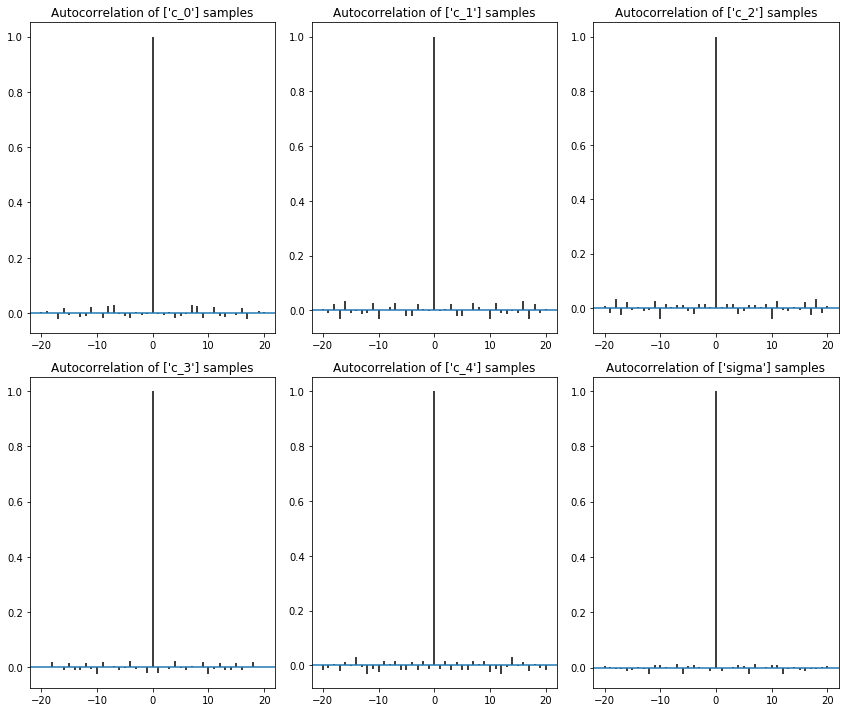

In [142]:
#autocorrelation plots
parameters = ['c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'sigma']
polynomial_samples = results_model_edited.extract()

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. 
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))





fig, axes =plt.subplots(2,3,figsize=(12,10))
for i in range(len(parameters)):
    plt.subplot(2, 3, i+1)
    plot_acf(polynomial_samples[parameters[i]])
    plt.title(f'Autocorrelation of {[parameters[i]]} samples')
fig.tight_layout()
plt.show()

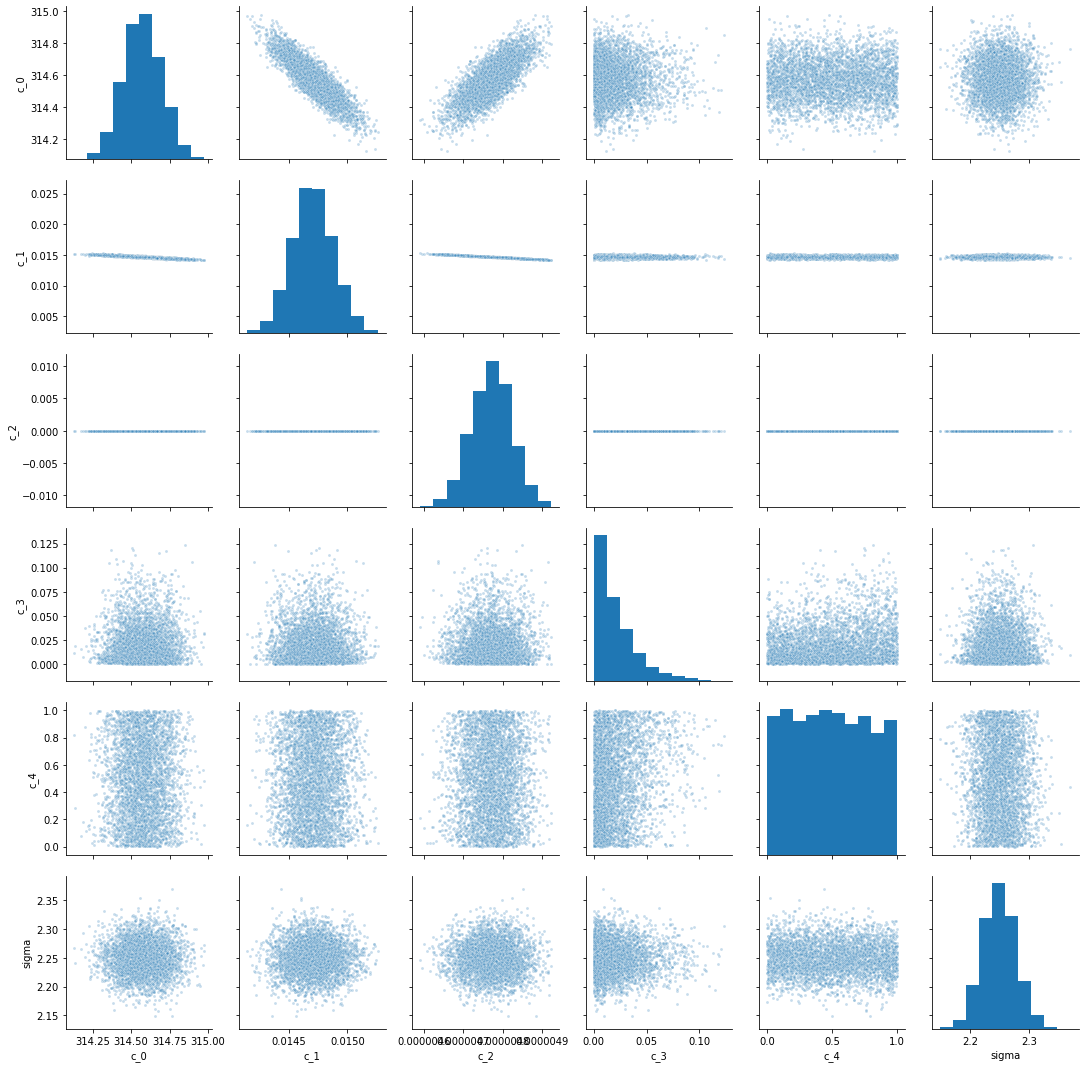

In [18]:
#pair plots
df = pd.DataFrame(
    data=np.transpose([polynomial_samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

The graphs agree with our expectations that the samples extracted are not correlated and the pir plots show that the chains converged without multimodality.

## **Models Comparison**
Now, we can plot the two models against the observed data to make sure that the new model fits the data better:

In [0]:
#These functions take the mean of the samples for the paramters and use them to generate a simulated value for the concentration
def predict_linear_mean(samples, dates):
  dates = np.array(dates)
  return stats.norm.rvs(
            np.mean(samples['c_0'])+np.mean(samples['c_1'])*dates +(np.mean(samples['c_2']) * np.cos((2*np.pi*dates)/365.25 + np.mean(samples['c_3']))),
            np.mean(samples['sigma']))
  
def predict_polynomial_mean(samples, dates):
  dates = np.array(dates)
  return stats.norm.rvs(
            np.mean(samples['c_0'])+np.mean(samples['c_1'])*dates+ np.mean(samples['c_2'])*(dates**2) +(np.mean(samples['c_3']) * np.cos((2*np.pi*dates)/365.25 + np.mean(samples['c_4']))),
            np.mean(samples['sigma']))
  

def predict_linear_percentile(samples, dates, num):
  dates = np.array(dates)
  return stats.norm.rvs(
             np.percentile(samples['c_0'], num)+np.percentile(samples['c_1'], num)*dates +
             (np.percentile(samples['c_2'], num)) * np.cos((2*np.pi*dates)/365.25 + np.percentile(samples['c_3'], num)),np.percentile(samples['sigma'], num))
  



def predict_polynomial_percentile(samples, dates, num):
  dates = np.array(dates)
  return stats.norm.rvs(
             np.percentile(samples['c_0'], num)+np.percentile(samples['c_1'], num)*dates +np.percentile(samples['c_2'],num)*(dates**2)+
             (np.percentile(samples['c_3'], num)) * np.cos((2*np.pi*dates)/365.25 + np.percentile(samples['c_4'], num)),
             np.percentile(samples['sigma'], num))




In [0]:
polynomial = predict_polynomial_mean(polynomial_samples, weeks)
linear = predict_linear_mean(linear_samples, weeks)

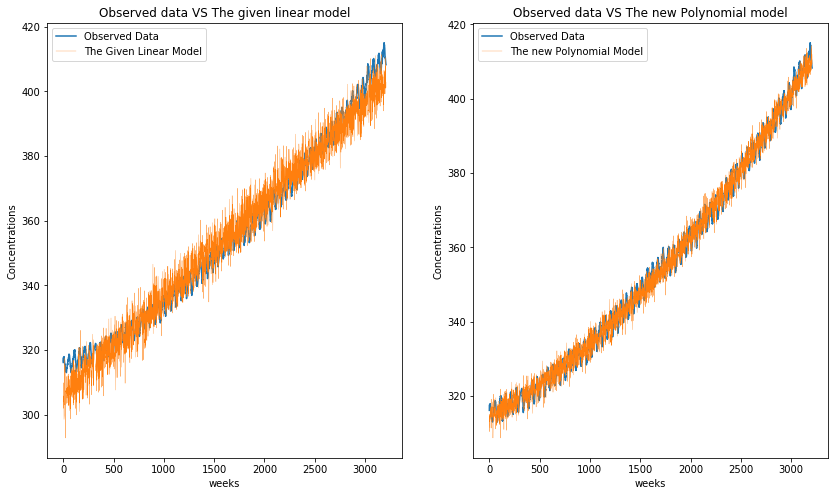

In [21]:
plt.subplots(1,2,figsize=(14,8))

plt.subplot(1, 2, 1)
plt.plot(weeks, data['Concentration(ppm)'], label="Observed Data")
plt.plot(weeks, linear, label="The Given Linear Model", linewidth = 0.3)
plt.xlabel('weeks')
plt.ylabel("Concentrations")
plt.title("Observed data VS The given linear model")
plt.legend()

###

plt.subplot(1, 2, 2)
plt.plot(weeks, data['Concentration(ppm)'], label="Observed Data")
plt.plot(weeks, polynomial, label="The new Polynomial Model", linewidth = 0.3)
plt.xlabel('weeks')
plt.ylabel("Concentrations")
plt.title("Observed data VS The new Polynomial model")
plt.legend()

plt.show()

For better visualization, we can can take a closeup at the model:

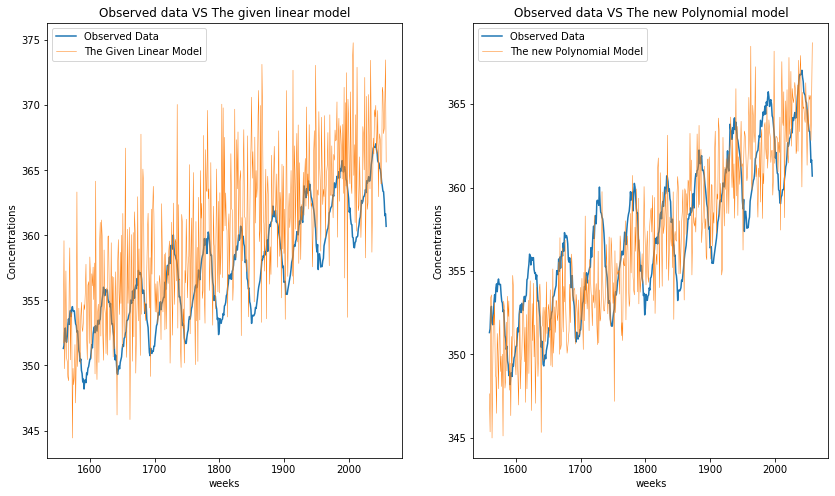

In [22]:
plt.subplots(1,2,figsize=(14,8))

plt.subplot(1, 2, 1)
plt.plot(weeks[1500:2000], data['Concentration(ppm)'][1500:2000], label="Observed Data")
plt.plot(weeks[1500:2000], linear[1500:2000], label="The Given Linear Model", linewidth = 0.5)
plt.xlabel('weeks')
plt.ylabel("Concentrations")
plt.title("Observed data VS The given linear model")
plt.legend()

###

plt.subplot(1, 2, 2)
plt.plot(weeks[1500:2000], data['Concentration(ppm)'][1500:2000], label="Observed Data")
plt.plot(weeks[1500:2000], polynomial[1500:2000], label="The new Polynomial Model", linewidth = 0.5)
plt.xlabel('weeks')
plt.ylabel("Concentrations")
plt.title("Observed data VS The new Polynomial model")
plt.legend()

plt.show()

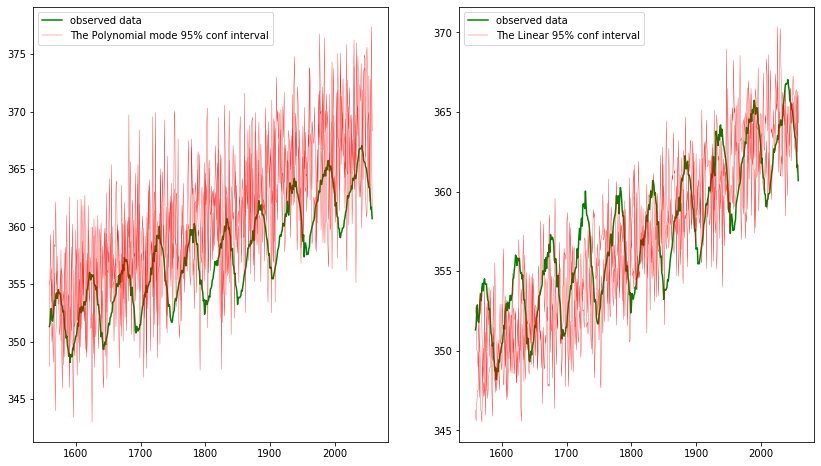

In [23]:
poly_top = predict_polynomial_percentile(polynomial_samples, weeks, 97.5)
poly_bottom = predict_polynomial_percentile(polynomial_samples, weeks, 2.5)

linear_top = predict_linear_percentile(linear_samples, weeks, 97.5)
linear_bottom = predict_linear_percentile(linear_samples, weeks, 2.5)

plt.subplots(1,2,figsize=(14,8))


plt.subplot(1, 2, 1)
plt.plot(weeks[1500:2000], data['Concentration(ppm)'][1500:2000], color = 'green', label='observed data')

plt.plot(weeks[1500:2000], linear_top[1500:2000], linewidth = .3, color = 'red')

plt.plot(weeks[1500:2000],linear_bottom[1500:2000], linewidth = .3, color = 'red', label = "The Polynomial mode 95% conf interval")
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(weeks[1500:2000], data['Concentration(ppm)'][1500:2000], color = 'green',label='observed data')

plt.plot(weeks[1500:2000], poly_top[1500:2000], linewidth = .3, color = 'red')

plt.plot(weeks[1500:2000],poly_bottom[1500:2000], linewidth = .3, color = 'red', label = "The Linear 95% conf interval")
plt.legend()



plt.show()

Looking at the plots above, we see that the polynomial model is a much better fit for the data as we expect and its 95% confidence interval is narrower.

##**Future Predictions**
Now, we can use the new model to make predictions about the future CO2 concentrations.

In [0]:
#making the data for the future:
#from 2019 to 2058 -> 39 years
future_weeks = [weeks[-1]]
#39 years and assuming that each year has 52 weeks
for i in range(39*52):  
  future_weeks.append(future_weeks[-1]+1)

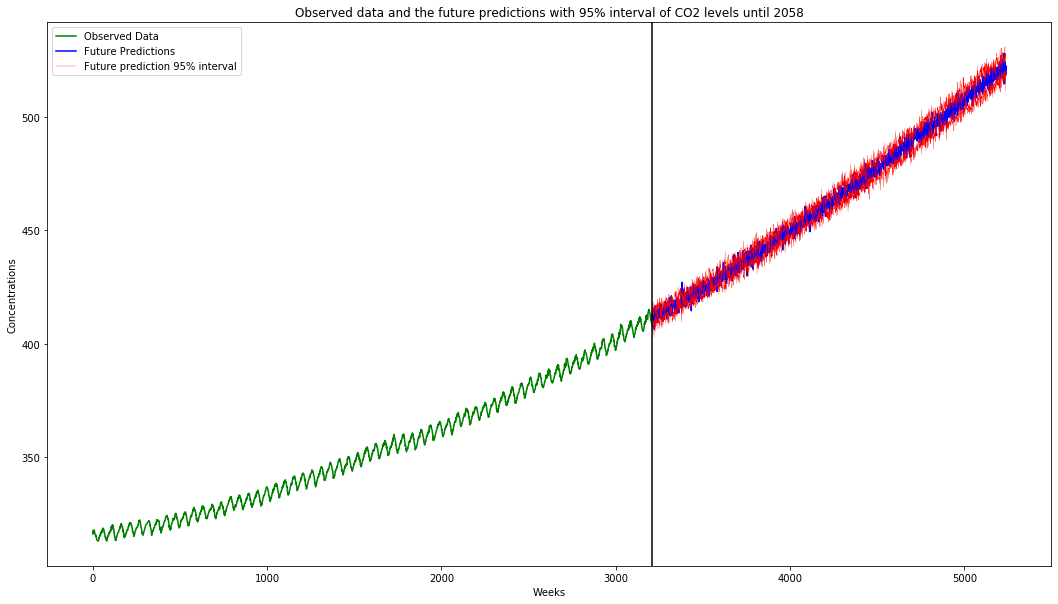

In [25]:
future_prediction = predict_polynomial_mean(polynomial_samples, future_weeks)
future_prediction_top = predict_polynomial_percentile(polynomial_samples, future_weeks, 97.5)
future_prediction_bottom = predict_polynomial_percentile(polynomial_samples, future_weeks, 2.5)


plt.figure(figsize = (18,10))
plt.plot(weeks, data['Concentration(ppm)'], color = 'green',label = 'Observed Data')
plt.plot(future_weeks, future_prediction, color = 'blue', label = 'Future Predictions')

plt.plot(future_weeks, future_prediction_top, color = 'red', label = 'Future prediction 95% interval', linewidth = 0.3)
plt.plot(future_weeks, future_prediction_bottom, color = 'red',linewidth = 0.3)
plt.legend()

plt.title("Observed data and the future predictions with 95% interval of CO2 levels until 2058")
plt.xlabel("Weeks")
plt.ylabel("Concentrations")
plt.axvline(weeks[-1], color='black')

plt.show()



The graph above shows the future predictions of the CO2 concentrations. We can see that by 2058, the concentration is going to be over 500ppm. 
We can take a closer look to see when levels of 450ppm will be reached:

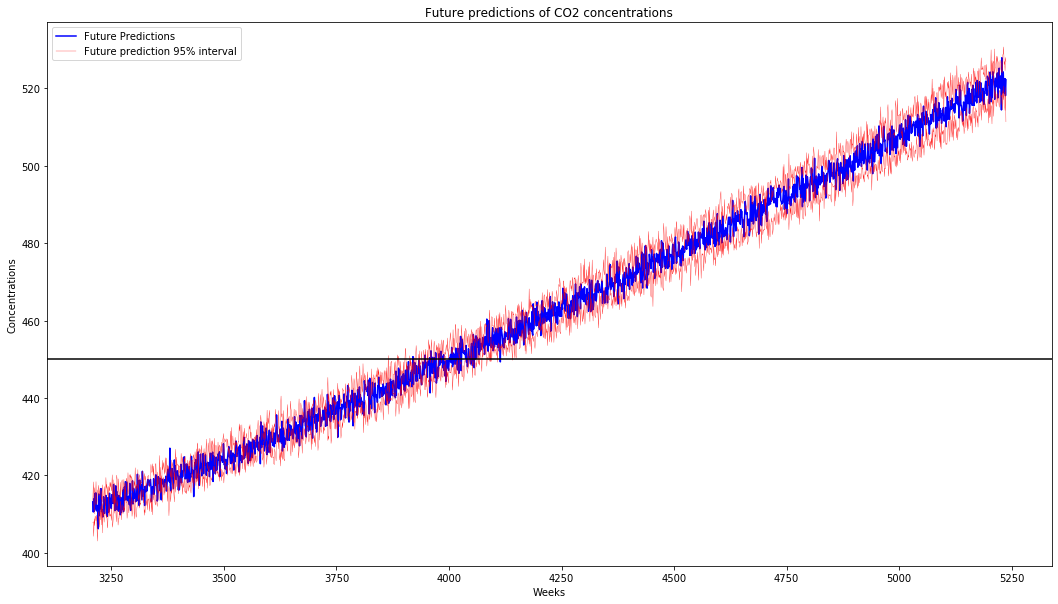

In [26]:
plt.figure(figsize = (18,10))
plt.plot(future_weeks, future_prediction, color = 'blue', label = 'Future Predictions')

plt.plot(future_weeks, future_prediction_top, color = 'red', label = 'Future prediction 95% interval', linewidth = 0.3)
plt.plot(future_weeks, future_prediction_bottom, color = 'red',linewidth = 0.3)
plt.legend()

plt.title("Future predictions of CO2 concentrations")
plt.xlabel("Weeks")
plt.ylabel("Concentrations")
plt.axhline(450, color='black')

plt.show()


From the graph, we notice that the levels of 450ppm will be reached after approximately 4000 weeks from 1958 ( 1958+(4000/52)=2034 ) so the levels will be obtained around 2034. To be more certain, we can explore the model confidence interval around this time: 

In [0]:
future_years = copy.deepcopy(future_weeks)

for i, week in enumerate(future_years):
  future_years[i] = int(1958+(week/52))



table = pd.DataFrame({'Weeks': np.array(future_years),
                                'Co2 mean concentrations': future_prediction,
                                '95% bottom': future_prediction_bottom,
                                '95% top': future_prediction_top})



In [123]:
table.loc[(table['95% bottom']>=445)][:20]

,Weeks,Co2 mean concentrations,95% bottom,95% top
657,2032,438.616267,445.270516,447.617877
685,2032,444.718671,445.091732,447.131670
713,2033,446.846661,446.546930,445.680832
718,2033,444.321589,445.353752,453.554537
724,2033,449.683351,445.200642,451.293667
729,2033,444.982637,446.093540,448.671172
731,2033,445.062752,445.856700,449.912300
735,2033,447.940818,445.605246,452.384159
736,2033,446.030099,447.293375,450.372886
739,2033,447.814604,446.249093,452.603524


According to our model, by the end of year 2032, we are 95% confident that the concentration of CO2 will be between 445 and 447 ppm. And since the concentration is undergoing an increasing overall trend, then this means that there is a very strong probability that by the end of the year 2033, the CO2 levels will pass 450 ppm.

##**Model Shortcomings**
In this section, I will explore the statistical differences between my model and the real data to show the area of improvemens in my model.

In [0]:
#The test statistic functions:
def mean_ts(replicated_data):
  return np.mean(replicated_data)

def std_ts(replicated_data):
  return np.std(replicated_data)

In [0]:
#generating 1000 replicated datasets from the mode:
weeks = np.array(weeks)
replicated_data = []
for i in range(1000): #for each sample of the paramter, I use it to generate one replicated dataset.
    replicated_data.append((stats.norm.rvs(
            polynomial_samples['c_0'][i]+polynomial_samples['c_1'][i]*weeks+ polynomial_samples['c_2'][i]*(weeks**2) +
            polynomial_samples['c_3'][i] * np.cos((2*np.pi*weeks)/365.25 + polynomial_samples['c_4'][i])),
            polynomial_samples['sigma'][i]))

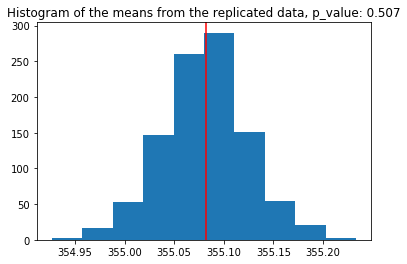

In [263]:
# for the mean:
statistic_real = mean_ts(data['Concentration(ppm)'])# Getting the  mean of the real data

statistic_replicated = np.array([mean_ts(i[0]) for i in replicated_data]) # Getting the mean of the
#replicated data

#plotting the histogram
plt.hist(statistic_replicated)#the histogram
plt.axvline(statistic_real, color='red') #the line of the real data

p=((statistic_replicated>statistic_real).sum())/len(statistic_replicated)#the p_value (proportion of histogram to the right
# of the line)

plt.title(f'Histogram of the means from the replicated data, p_value: {p}')
plt.show()

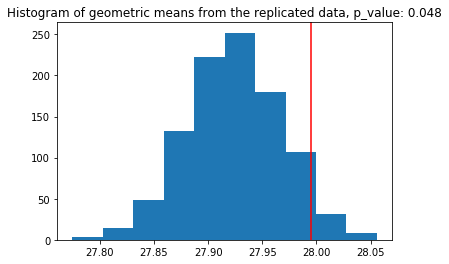

In [264]:
statistic_real = std_ts(data['Concentration(ppm)'])# Getting the standard deviation of the real data

statistic_replicated = np.array([std_ts(i[0]) for i in replicated_data]) # Getting the standard deviation of the
#replicated data

#plotting the histogram
plt.hist(statistic_replicated)#the histogram
plt.axvline(statistic_real, color='red') #the line of the real data

p=((statistic_replicated>statistic_real).sum())/len(statistic_replicated)#the p_value (proportion of histogram to the right
# of the line)

plt.title(f'Histogram of geometric means from the replicated data, p_value: {p}')
plt.show()

From the two plots above, we see that the model does a good job at predicting the mean of the real dataset since the p_value that we obtained is 0.507 which is between 0.95 and 0.05. However, looking at the standard deviation plot, we see that the p_value is actually less than 0.05 which means that this model does a poor job at simulating the standard deviation of the real dataset. This might happen because the real dataset of CO2 has some variations that is hard to predict, this variation happens because of the rapid change in the CO2 levels that might be due to human activities (increase in industrial production at one year). This is an area of improvement for the model, this model is relatevly simple with not many paramters, to account for the variation and predict standard deviation better, the model might include more paramters to better simulate variations and rapid increase/decrease in CO2 levels.